We will use GRU and LSTM models for a time series prediction job, and we will compare the GRU model's performance to that of an LSTM model. The purpose of this implementation is to **create a model that can reliably anticipate energy use in the following hour**

In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm.notebook import tqdm as tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

# **Load Dataset**

In [2]:
dataset1 = 'https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/AEP_hourly.csv'
dataset2 = 'https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/COMED_hourly.csv'
dataset3 = 'https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/DAYTON_hourly.csv'
dataset4 = 'https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/DEOK_hourly.csv'
dataset5 = 'https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/DOM_hourly.csv'
dataset6 = 'https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/DUQ_hourly.csv'
dataset7 = 'https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/EKPC_hourly.csv'
dataset8 = 'https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/FE_hourly.csv'
dataset8 = 'https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/NI_hourly.csv'
dataset9 = 'https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/PJME_hourly.csv'
dataset10 = 'https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/PJMW_hourly.csv'
dataset11 = 'https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/PJM_Load_hourly.csv'

# Load each dataset
df1 = pd.read_csv(dataset1)
df2 = pd.read_csv(dataset2)
df3 = pd.read_csv(dataset3)
df4 = pd.read_csv(dataset4)
df5 = pd.read_csv(dataset5)
df6 = pd.read_csv(dataset6)
df7 = pd.read_csv(dataset7)
df8 = pd.read_csv(dataset8)
df9 = pd.read_csv(dataset9)
df10 = pd.read_csv(dataset10)
df11 = pd.read_csv(dataset11)

# Concatenate the datasets
# merged_df = pd.concat([df1, df2, df3, df4, df5])

# Display the merged DataFrame
df4.head()


,Datetime,DEOK_MW
0,2012-12-31 01:00:00,2945.0
1,2012-12-31 02:00:00,2868.0
2,2012-12-31 03:00:00,2812.0
3,2012-12-31 04:00:00,2812.0
4,2012-12-31 05:00:00,2860.0


**format dataset time**
- Hour of the day *i.e. 0-23*
- Day of the week *i.e. 1-7*
- Month *i.e. 1-12*
- Day of the year *i.e. 1-365*
        
Group the data into sequences (**window_size period**) is the number of data points in history that the model will use to make the prediction
    

# **Create training instances using sliding window**

In [3]:
def move_sliding_window(data, window_size, inputs_cols_indices, label_col_index):
    # (# instances created by movement, seq_len (timestamps), # features (input_len))
    inputs = np.zeros((len(data) - window_size, window_size, len(inputs_cols_indices)))
    labels = np.zeros(len(data) - window_size)

    for i in range(window_size, len(data)):
        inputs[i - window_size] = data[i - window_size : i, inputs_cols_indices]
        labels[i - window_size] = data[i, label_col_index]
    inputs = inputs.reshape(-1, window_size, len(inputs_cols_indices))
    labels = labels.reshape(-1, 1)
    print(inputs.shape, labels.shape)

    return inputs, labels

# **Build the Training Set**

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm_notebook
import requests
from io import StringIO

# Definisi fungsi move_sliding_window
def move_sliding_window(data, window_size, inputs_cols_indices, label_col_index):
    inputs = []
    labels = []
    for i in range(len(data) - window_size):
        inputs.append(data[i:i + window_size, inputs_cols_indices])
        labels.append(data[i + window_size, label_col_index])
    return np.array(inputs), np.array(labels)

# Definisi variabel label_col_index, inputs_cols_indices, window_size
label_col_index = 0  # consumption as label to predict
inputs_cols_indices = range(5)  # use (consumption, hour, dayofweek, month, dayofyear) columns as features
window_size = 90

# Definisi variabel train_x, test_x, test_y
label_scalers = {}
train_x = []
test_x = {}
test_y = {}

# URL dataset
dataset_urls = [
    'https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/AEP_hourly.csv',
    'https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/COMED_hourly.csv',
    'https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/DAYTON_hourly.csv',
    'https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/DEOK_hourly.csv',
    'https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/DOM_hourly.csv'
]

num_files_for_dataset = 5

for url in tqdm_notebook(dataset_urls[:num_files_for_dataset]):
    print(f"Processing {url} ...")
    # Mengunduh file CSV
    response = requests.get(url)
    if response.status_code == 200:
        # Membaca file CSV ke dalam DataFrame Pandas
        df = pd.read_csv(StringIO(response.text), parse_dates=["Datetime"])

        # Memproses data waktu menjadi format yang sesuai untuk input
        df["hour"] = df.apply(lambda x: x["Datetime"].hour, axis=1)
        df["dayofweek"] = df.apply(lambda x: x["Datetime"].dayofweek, axis=1)
        df["month"] = df.apply(lambda x: x["Datetime"].month, axis=1)
        df["dayofyear"] = df.apply(lambda x: x["Datetime"].dayofyear, axis=1)
        df = df.sort_values("Datetime").drop("Datetime", axis=1)

        # Melakukan penskalaan pada data input
        sc = MinMaxScaler()
        label_sc = MinMaxScaler()
        data = sc.fit_transform(df.values)

        # Mendapatkan objek penskalaan untuk label (data penggunaan) agar output dapat diubah kembali ke nilai aktual selama evaluasi
        label_sc.fit(df.iloc[:, label_col_index].values.reshape(-1, 1))
        label_scalers[url] = label_sc

        # Memindahkan jendela
        inputs, labels = move_sliding_window(
            data,
            window_size,
            inputs_cols_indices=inputs_cols_indices,
            label_col_index=label_col_index,
        )

        # Menggabungkan data dari semua file .csv
        test_portion = int(0.1 * len(inputs))
        if len(train_x) == 0:  # iterasi pertama
            train_x = inputs[:-test_portion]
            train_y = labels[:-test_portion]
        else:
            train_x = np.concatenate((train_x, inputs[:-test_portion]))
            train_y = np.concatenate((train_y, labels[:-test_portion]))
        test_x[url] = inputs[-test_portion:]
        test_y[url] = labels[-test_portion:]
    else:
        print(f"Failed to download {url}")

  0%|          | 0/5 [00:00<?, ?it/s]

Processing https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/AEP_hourly.csv ...
Processing https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/COMED_hourly.csv ...
Processing https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/DAYTON_hourly.csv ...
Processing https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/DEOK_hourly.csv ...
Processing https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/DOM_hourly.csv ...


# **Pytorch Data Loaders**

In [5]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

# Konversi train_x dan train_y menjadi numpy array
train_x = np.array(train_x)
train_y = np.array(train_y)

# Buat TensorDataset dari numpy array
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))

# Cetak ukuran tensor dari input pertama dan label pertama
print(train_data[0][0].shape)  # Cetak ukuran tensor dari input pertama
print(train_data[0][1].shape)  # Cetak ukuran tensor dari label pertama

torch.Size([90, 5])
torch.Size([])


In [6]:
batch_size = 1024
#batch_size = 2048

import torch
from torch.utils.data import TensorDataset, DataLoader

# Konversi train_x dan train_y menjadi numpy array
train_x = np.array(train_x)
train_y = np.array(train_y)

# Buat TensorDataset dari numpy array
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))

# Drop the last incomplete batch
train_loader = DataLoader(
    train_data, shuffle=True, batch_size=batch_size, drop_last=True
)

In [7]:
print(
    f"Train Size: {train_x.shape}, Batch Size: {batch_size}, # of iterations per epoch: {int(train_x.shape[0]/batch_size)}"
)

Train Size: (434274, 90, 5), Batch Size: 1024, # of iterations per epoch: 424


In [8]:
train_x.shape, test_x[dataset4].shape

((434274, 90, 5), (5764, 90, 5))

In [9]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")

GPU is available


In [10]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(
            input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.gru(x, h)
        # print(out[:, -1].shape, h.shape)
        # select hidden state of last timestamp (t=90) (1024, 256)
        out = self.fc(self.relu(out[:, -1]))  # out[:, -1, :]
        # print(out.shape) # (1024, 1)
        return out, h

    def init_hidden(self, batch_size):
        # Initialze h_0 with zeros
        weight = next(self.parameters()).data
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        )
        return hidden


class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:, -1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        # Initialze h_0, c_0 with zeros
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim)
            .zero_()
            .to(device),  # h_0
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        )
        return hidden

In [14]:
def train(
    train_loader,
    learn_rate,
    hidden_dim=256,
    n_layers=2,
    n_epochs=5,
    model_type="GRU",
    print_every=100,
):

    input_dim = next(iter(train_loader))[0].shape[2]  # 5

    # Batch generator (train_data, train_label)
    # print(next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape) # torch.Size([1024, 90, 5]) torch.Size([1024, 1])

    output_dim = 1

    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)

    # Defining loss function and optimizer
    criterion = nn.MSELoss()  # Mean Squared Error
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []

    # Start training loop
    for epoch in range(1, n_epochs + 1):
        start_time = time.process_time()
        h = model.init_hidden(batch_size)
        avg_loss = 0.0
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            # Unpcak both h_0 and c_0
            elif model_type == "LSTM":
                h = tuple([e.data for e in h])

            # Set the gradients to zero before starting to do backpropragation because
            # PyTorch accumulates the gradients on subsequent backward passes
            model.zero_grad()

            out, h = model(x.to(device).float(), h)
            label = label.view(-1, 1)
            loss = criterion(out, label.to(device).float())

            # Perform backpropragation
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            if counter % print_every == 0:
                print(
                    f"Epoch {epoch} - Step: {counter}/{len(train_loader)} - Average Loss for Epoch: {avg_loss/counter}"
                )
        current_time = time.process_time()

        print(
            f"Epoch {epoch}/{n_epochs} Done, Total Loss: {avg_loss/len(train_loader)}"
        )

        print(f"Time Elapsed for Epoch: {current_time-start_time} seconds")

        epoch_times.append(current_time - start_time)

    print(f"Total Training Time: {sum(epoch_times)} seconds")
    return model

## **Training the GRU model**

In [15]:
# seq_len = 90  # (timestamps)
n_hidden = 256
n_layers = 2
n_epochs = 5
print_every = 100
lr = 0.001
gru_model = train(
    train_loader,
    learn_rate=lr,
    hidden_dim=n_hidden,
    n_layers=n_layers,
    n_epochs=n_epochs,
    model_type="GRU",
    print_every=print_every,
)

Starting Training of GRU model
Epoch 1 - Step: 100/424 - Average Loss for Epoch: 0.012798082616645843
Epoch 1 - Step: 200/424 - Average Loss for Epoch: 0.007096216358477249
Epoch 1 - Step: 300/424 - Average Loss for Epoch: 0.005034331739104042
Epoch 1 - Step: 400/424 - Average Loss for Epoch: 0.0039352032291935755
Epoch 1/5 Done, Total Loss: 0.003743931453566304
Time Elapsed for Epoch: 20.649254394999986 seconds
Epoch 2 - Step: 100/424 - Average Loss for Epoch: 0.0005399062810465693
Epoch 2 - Step: 200/424 - Average Loss for Epoch: 0.0004797292313014623
Epoch 2 - Step: 300/424 - Average Loss for Epoch: 0.00044394910878812273
Epoch 2 - Step: 400/424 - Average Loss for Epoch: 0.00041626538761192934
Epoch 2/5 Done, Total Loss: 0.0004102876240344727
Time Elapsed for Epoch: 20.50337466299999 seconds
Epoch 3 - Step: 100/424 - Average Loss for Epoch: 0.0003082917863503098
Epoch 3 - Step: 200/424 - Average Loss for Epoch: 0.0002982300735311583
Epoch 3 - Step: 300/424 - Average Loss for Epoch: 

## **Training the LSTM model**

In [16]:
lstm_model = train(
    train_loader,
    learn_rate=lr,
    hidden_dim=n_hidden,
    n_layers=n_layers,
    n_epochs=n_epochs,
    model_type="LSTM",
    print_every=print_every,
)

Starting Training of LSTM model
Epoch 1 - Step: 100/424 - Average Loss for Epoch: 0.01585028908913955
Epoch 1 - Step: 200/424 - Average Loss for Epoch: 0.009059097651625053
Epoch 1 - Step: 300/424 - Average Loss for Epoch: 0.00648231031644779
Epoch 1 - Step: 400/424 - Average Loss for Epoch: 0.0050863565801410006
Epoch 1/5 Done, Total Loss: 0.00484411428967504
Time Elapsed for Epoch: 24.715729576 seconds
Epoch 2 - Step: 100/424 - Average Loss for Epoch: 0.0006382431989186443
Epoch 2 - Step: 200/424 - Average Loss for Epoch: 0.0005703186901519075
Epoch 2 - Step: 300/424 - Average Loss for Epoch: 0.0005236408085329458
Epoch 2 - Step: 400/424 - Average Loss for Epoch: 0.0004803570068179397
Epoch 2/5 Done, Total Loss: 0.00047064620182181725
Time Elapsed for Epoch: 24.746460959000046 seconds
Epoch 3 - Step: 100/424 - Average Loss for Epoch: 0.00030090489191934465
Epoch 3 - Step: 200/424 - Average Loss for Epoch: 0.0002821823552949354
Epoch 3 - Step: 300/424 - Average Loss for Epoch: 0.00027

## **Save Model**

In [17]:
from google.colab import drive
drive.mount('/content/drive')

# Simpan model ke Google Drive
torch.save(gru_model.state_dict(), "/content/drive/My Drive/models/gru_model.pt")
torch.save(lstm_model.state_dict(), "/content/drive/My Drive/models/lstm_model.pt")


Mounted at /content/drive


# **Models Evaluation**

This is the formula for *sMAPE*:

$sMAPE = \frac{100%}{n} \sum_{t=1}^n \frac{|F_t - A_t|}{(|F_t + A_t|)/2}$


## **Load Model**

In [18]:
from google.colab import drive
drive.mount('/content/drive')

# Muat model dari Google Drive
gru_model.load_state_dict(torch.load("/content/drive/My Drive/models/gru_model.pt"))
lstm_model.load_state_dict(torch.load("/content/drive/My Drive/models/lstm_model.pt"))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<All keys matched successfully>

In [19]:
# move device to cpu for evaluation to avoid GPU memory run
device = "cpu"

In [20]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
gru_model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
#gru_model.load_state_dict(torch.load("./models/gru_model.pt"))

In [21]:
# Move the model to the appropriate device
gru_model.to(device)

GRUNet(
  (gru): GRU(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

In [22]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
lstm_model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
#lstm_model.load_state_dict(torch.load("./models/lstm_model.pt"))

In [23]:
# Move the model to the appropriate device
lstm_model.to(device)

LSTMNet(
  (lstm): LSTM(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

In [24]:
def sMAPE(outputs, targets):
    sMAPE = (
        100
        / len(targets)
        * np.sum(np.abs(outputs - targets) / (np.abs(outputs + targets)) / 2)
    )
    return sMAPE

In [25]:
def evaluate(model, test_x, test_y, label_scalers, batch_size):
    model.eval()
    outputs = []
    targets = []
    start_time = time.process_time()
    # Iterate through each file in test data
    for file in test_x.keys():
        file_outputs = []
        file_targets = []
        inputs = torch.from_numpy(np.array(test_x[file]))
        labels = torch.from_numpy(np.array(test_y[file]))

        num_batches = (inputs.shape[0] + batch_size - 1) // batch_size  # Calculate number of batches

        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, inputs.shape[0])
            batch_inputs = inputs[start_idx:end_idx]
            batch_labels = labels[start_idx:end_idx]

            h = model.init_hidden(batch_inputs.shape[0])

            # Predict outputs
            with torch.no_grad():
                out, h = model(batch_inputs.to(device).float(), h)

            file_outputs.append(
                label_scalers[file]
                .inverse_transform(out.cpu().detach().numpy())
                .reshape(-1)
            )

            file_targets.append(
    label_scalers[file].inverse_transform(batch_labels.numpy().reshape(-1, 1)).reshape(-1)
)

        outputs.append(np.concatenate(file_outputs))
        targets.append(np.concatenate(file_targets))

    # Merge all files
    concatenated_outputs = np.concatenate(outputs)
    concatenated_targets = np.concatenate(targets)

    print(f"Evaluation Time: {time.process_time()-start_time}")
    print(f"sMAPE: {round(sMAPE(concatenated_outputs, concatenated_targets), 3)}%")

    return outputs, targets, sMAPE

# Set batch size
batch_size = 1024

# Evaluate GRU model
#gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_scalers, batch_size)

# Evaluate LSTM model
#lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers, batch_size)


In [36]:
def evaluate(model, test_x, test_y, label_scalers, batch_size):
    model.eval()
    outputs = []
    targets = []
    start_time = time.process_time()
    # Iterate through each file in test data
    for file in test_x.keys():
        file_outputs = []
        file_targets = []
        inputs = torch.from_numpy(np.array(test_x[file]))
        labels = torch.from_numpy(np.array(test_y[file]))

        num_batches = (inputs.shape[0] + batch_size - 1) // batch_size  # Calculate number of batches

        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, inputs.shape[0])
            batch_inputs = inputs[start_idx:end_idx]
            batch_labels = labels[start_idx:end_idx]

            h = model.init_hidden(batch_inputs.shape[0])

            # Predict outputs
            with torch.no_grad():
                out, h = model(batch_inputs.to(device).float(), h)

            file_outputs.append(
                label_scalers[file]
                .inverse_transform(out.cpu().detach().numpy())
                .reshape(-1)
            )

            file_targets.append(
                label_scalers[file].inverse_transform(batch_labels.numpy().reshape(-1, 1)).reshape(-1)
            )

        outputs.append(np.concatenate(file_outputs))
        targets.append(np.concatenate(file_targets))

    # Merge all files
    concatenated_outputs = np.concatenate(outputs)
    concatenated_targets = np.concatenate(targets)

    print(f"Evaluation Time: {time.process_time()-start_time}")
    print(f"sMAPE: {round(sMAPE(concatenated_outputs, concatenated_targets), 3)}%")

    return outputs, targets, sMAPE(concatenated_outputs, concatenated_targets)

def sMAPE(outputs, targets):
    sMAPE = (
        100
        / len(targets)
        * np.sum(np.abs(outputs - targets) / (np.abs(outputs) + np.abs(targets)) / 2)
    )
    return sMAPE


## **Evaluate Model**

In [39]:
device = "cpu"  # Ganti "CPU" menjadi "cpu"

# Memuat model dari Google Drive
gru_model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
gru_model.load_state_dict(torch.load("/content/drive/My Drive/models/gru_model.pt"))
gru_model.to(device)  # Pindahkan model ke perangkat yang benar

lstm_model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
lstm_model.load_state_dict(torch.load("/content/drive/My Drive/models/lstm_model.pt"))
lstm_model.to(device)  # Pindahkan model ke perangkat yang benar

# Evaluasi model
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_scalers, batch_size)
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers, batch_size)


Evaluation Time: 120.48641303399995
sMAPE: 0.297%
Evaluation Time: 115.81914665199997
sMAPE: 0.287%


In [40]:
len(
    gru_outputs
)  # list of predicted output file for each state (each element has a 1d array for that state)

5

# **Data Prediction Plotting**

In [41]:
states_list = list(test_x.keys())

In [42]:
states_list

['https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/AEP_hourly.csv',
 'https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/COMED_hourly.csv',
 'https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/DAYTON_hourly.csv',
 'https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/DEOK_hourly.csv',
 'https://raw.githubusercontent.com/arifadli/DatasetRepository/main/PrediksiEnergi/data/DOM_hourly.csv']

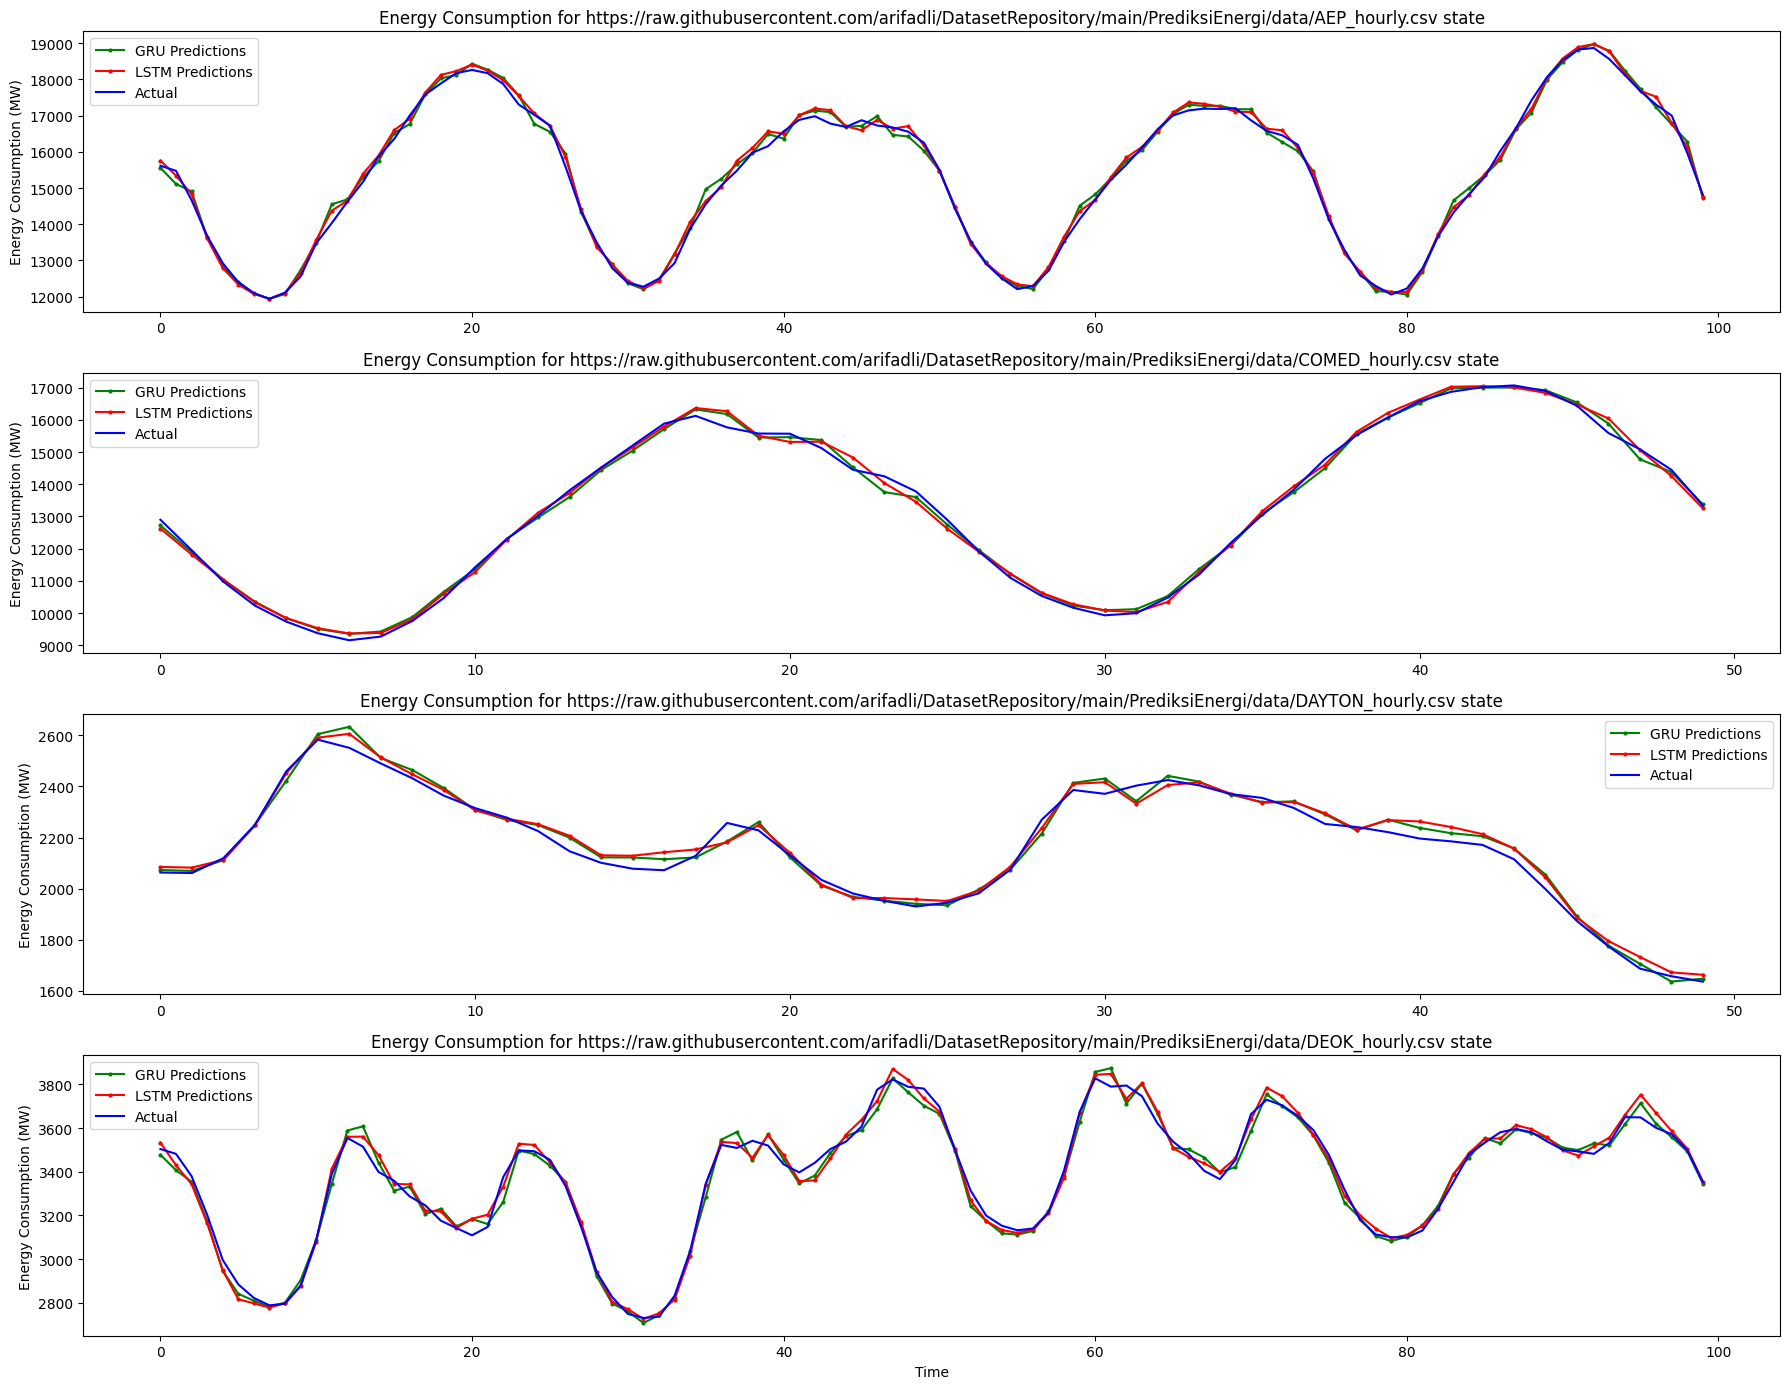

In [43]:
plt.figure(figsize=(18, 14))

# Grafik 1
plt.subplot(4, 1, 1)
plt.plot(gru_outputs[0][-100:], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_outputs[0][-100:], "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(targets[0][-100:], color="b", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[0]} state")
plt.legend()

# Grafik 2
plt.subplot(4, 1, 2)
plt.plot(gru_outputs[1][-50:], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_outputs[1][-50:], "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(targets[1][-50:], color="b", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[1]} state")
plt.legend()

# Grafik 3
plt.subplot(4, 1, 3)
plt.plot(gru_outputs[2][:50], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_outputs[2][:50], "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(targets[2][:50], color="b", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[2]} state")
plt.legend()

# Grafik 4
plt.subplot(4, 1, 4)
plt.plot(gru_outputs[3][:100], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_outputs[3][:100], "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(targets[3][:100], color="b", label="Actual")
plt.title(f"Energy Consumption for {states_list[3]} state")
plt.ylabel("Energy Consumption (MW)")
plt.xlabel("Time")
plt.legend()

# Tampilkan grafik
plt.tight_layout()
plt.show()
